# Introduction

### Competition: [Titanic Kaggle](https://www.kaggle.com/c/titanic/overview)

This is notebook contains a simple data science project framework, for learning and portfolio construction purposes.

# Libs

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Embedding,  Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.data import Dataset
from tensorflow import keras

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import QuantileTransformer,  KBinsDiscretizer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import metrics

import matplotlib.pyplot as plt

import optuna
from optuna.visualization import plot_contour, plot_edf, plot_intermediate_values, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_slice

### Models

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

# Load Dataset

This step we simply get our data to our working environment. Because we are not dealing with live data, a simple pandas usage is enough.

In [3]:
%%time

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

Wall time: 22.9 ms


# Exploratory Data Analysis

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Checking if Pclass has any effect on survival rate

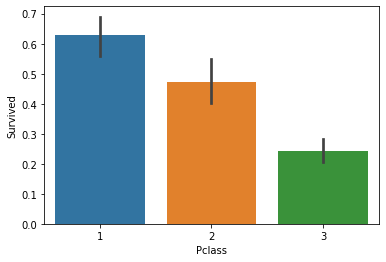

In [5]:
sns.barplot(x="Pclass", y="Survived", data=train);

Here we can see that Pclass is an important variable

### Checking Sex and Embarked

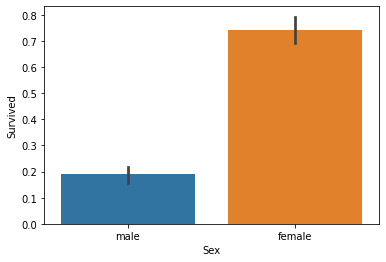

In [6]:
sns.barplot(x="Sex", y="Survived", data=train);

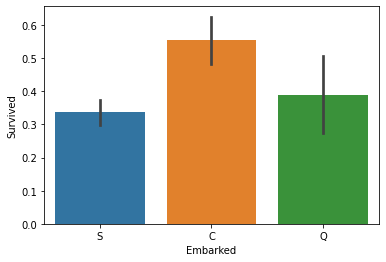

In [7]:
sns.barplot(x="Embarked", y="Survived", data=train);

We can see that the survival rate between females and males are most discrepant, and the *Embarked* variable has some effect as well.

- [x] Pclass
- [ ] Name
- [x] Sex
- [ ] Age
- [ ] SibSp
- [ ] Parch
- [ ] Ticket
- [ ] Fare
- [ ] Cabin
- [x] Embarked

## Let's verify the rest of categorical variables (Cabin, Name, Ticket)

### First, the Cabin variable

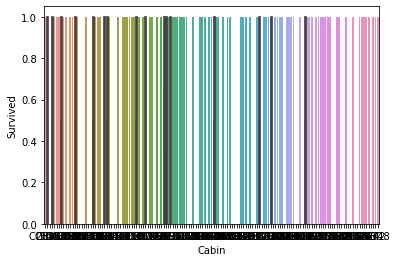

In [8]:
sns.barplot(x="Cabin", y="Survived", data=train);

We can't really use it this way, so let's change it a little:
Let's test three hipothesis:
- The letter is important;
- The number is important;
- Having it as missing or not is important.

In [9]:
train.loc[train['Cabin'].isna(), 'Cabin'] = 'missing'
cabin_letters = [s[0] for s in train['Cabin']]

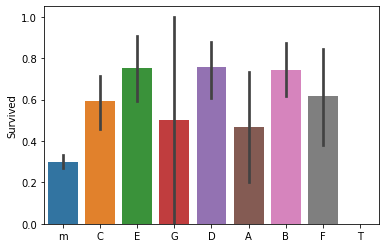

In [10]:
sns.barplot(x= cabin_letters, y=train["Survived"]);

Here we can see that the missing values don't really tell us anything, as it's mean is around the overall survival rate.

Overall, most of the error bars are too big for us to consider that the letter has anything to do with the survival rate. However, we will consider the C, E, D, B letters as they are statiscally different than the overall mean.

Before moving on, let's see if we can embed them in one variable.

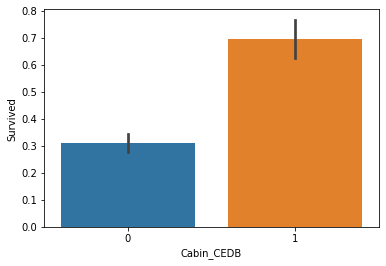

In [11]:
train['Cabin_CEDB'] = np.array([letter[0] in ['C', 'E', 'D', 'B'] for letter in train['Cabin']]).astype(int)
sns.barplot(x = train['Cabin_CEDB'], y = train["Survived"]);

Is the cabin number important?

In [12]:
cabin_numbers = [s.split()[0][1:] for s in train['Cabin']]
for i in range(len(cabin_numbers)):
    try:
        cabin_numbers[i] = int(cabin_numbers[i])
    except Exception:
        cabin_numbers[i] = np.nan

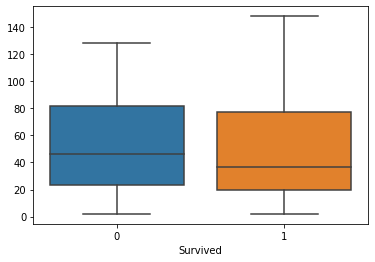

In [13]:
sns.boxplot(x = train["Survived"], y = cabin_numbers);

With this we can conclude that the number is not relevant!
- [x] The letter is important (**Important**);
- [x] The number is important (**Not Important**);
- [x] Having it as missing or not is important (**Not Important**).

### Next, the *Name* variable

In [14]:
len(train['Name'].unique())

891

Here we can see that every name here is unique, so we have to transform it a bit. 

The hipothesis tested is that the title of each name is relevant to predict the survival rate.

In [15]:
name_and_title = [name.split(", ")[1] for name in train['Name']]
title = [name.split(".")[0] for name in name_and_title]
print(len(title))

891


In [16]:
print(len(np.unique(title)))
np.unique(title)

17


array(['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master',
       'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir',
       'the Countess'], dtype='<U12')

In [17]:
pd.Series(title).value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Lady              1
Jonkheer          1
Ms                1
the Countess      1
Don               1
Sir               1
Mme               1
Capt              1
dtype: int64

Let's only consider the titles: Mr, Miss, Mrs and Master; as we don't have enough observations from the others

In [18]:
for i in range(len(title)):
    if title[i] not in ['Mr', 'Miss', 'Mrs', 'Master']:
        title[i] = 'Other'        

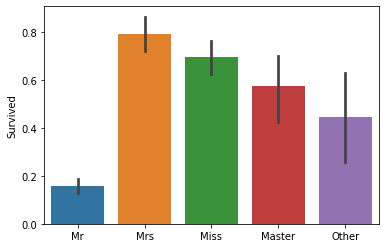

In [19]:
train['Name'] = title
sns.barplot(x = title, y = train["Survived"]);

The *Mrs* title is relevant, however it is probably highly correlated with the *Sex* variable.

Something intereting is the relevancy of the *Master* title, that probably has information about the economical power of the person.

### Lastly, the Ticket variable

In [20]:
train['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

Here we will test only one hipothesis:
- The letters have relevant information

In [21]:
tickets = [s.split()[0] for s in train['Ticket']]
for i in range(len(tickets)):
    try:
        int(tickets[i])
        tickets[i] = "number"
    except:
        tickets[i] = "Letter"

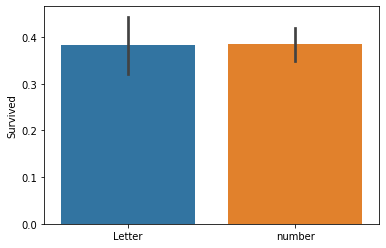

In [22]:
sns.barplot(x = tickets, y = train["Survived"]);

We can conclude here that the letter in the ticket variable most likely has not any relevant information.

- [x] Pclass
- [x] Name
- [x] Sex
- [ ] Age
- [ ] SibSp
- [ ] Parch
- [x] Ticket
- [ ] Fare
- [x] Cabin
- [x] Embarked

## Now, for the numerical variables (*Age*,	*SibSp*, *Parch*, *Fare*)

### Age

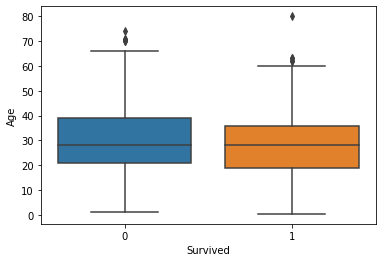

In [23]:
sns.boxplot(x = train["Survived"], y = train['Age']);

It looks like the average age does not differ when comparing the survived and not survived people.

### SibSp

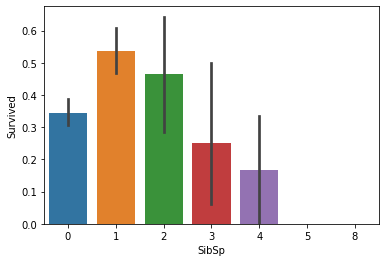

In [24]:
sns.barplot(x = train['SibSp'], y = train["Survived"]);

Only when SibSp = 1 that we have a relevant information.

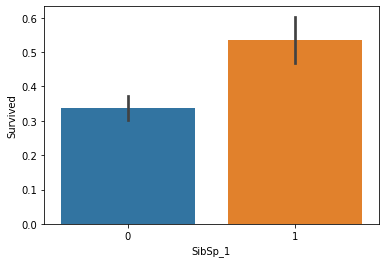

In [25]:
train['SibSp_1'] = (train['SibSp'] == 1).astype(int)
sns.barplot(x = train['SibSp_1'], y = train["Survived"]);

### Parch

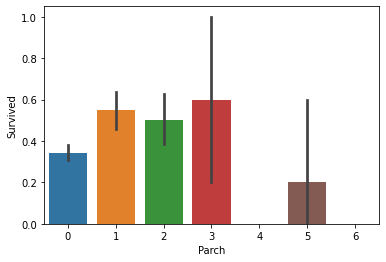

In [26]:
sns.barplot(x = train['Parch'], y = train["Survived"]);

We can have better predictions when Parch = 1 or 2

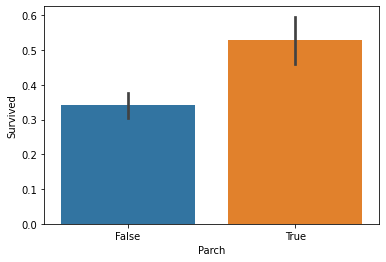

In [27]:
train['Parch_1_or_2'] = np.logical_or(train['Parch'] == 1, train['Parch'] == 2).astype(int)
sns.barplot(x = np.logical_or(train['Parch'] == 1, train['Parch'] == 2), y = train["Survived"]);

### Parch + SibSp

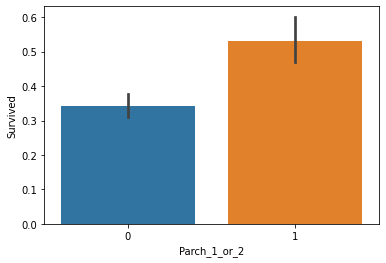

In [28]:
sns.barplot(x = train['Parch_1_or_2'], y = train["Survived"]);

Here we can see that from 4 Parch + SipSp, the survival rate decreases, so we will create a dummy variable for <4 relatives.

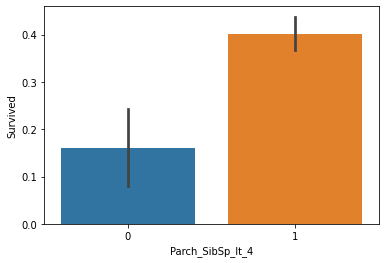

In [29]:
train['Parch_SibSp_lt_4'] = ((train['Parch'] + train['SibSp']) < 4).astype(int)
sns.barplot(x = train['Parch_SibSp_lt_4'], y = train["Survived"]);

### Fare

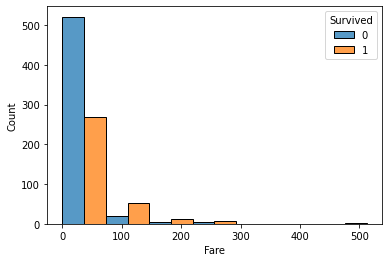

In [30]:
sns.histplot(multiple = 'dodge', x = train['Fare'], hue = train["Survived"], bins = 7);

Higher fares -> higher survival rates

- [x] Pclass
- [x] Name
- [x] Sex
- [x] Age
- [x] SibSp
- [x] Parch
- [x] Ticket
- [x] Fare
- [x] Cabin
- [x] Embarked

# Variable Selection
Using the EDA's results, the variable selection step will be manual.
For our model, we will initially use the variables:
* Pclass
* Sex
* Embarked
* Cabin (Dummy for when C, E, D or B)
* Name (Mr, Mrs, Miss, Master)
* SibSp (when equals 1)
* Parch (when equals 1 or 2)
* SibSp + Parch (when equals 4 or less)
* Fare

# Preprocessing

## Dealing with *Missings*

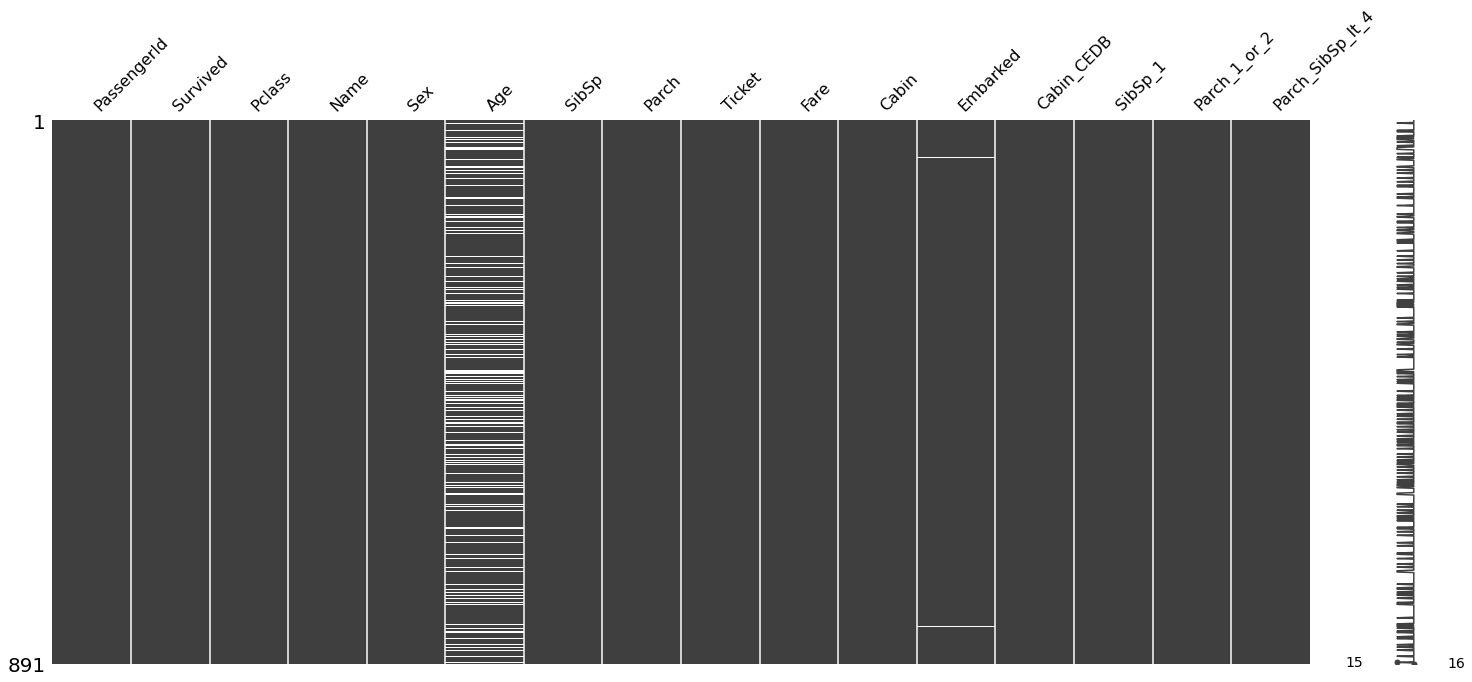

In [31]:
import missingno as msno
msno.matrix(train);

We will use the mode value for the Embarked variable. As the Age variable will not be used, we will not treat it.

In [32]:
train.loc[train.isna()['Embarked'],:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_CEDB,SibSp_1,Parch_1_or_2,Parch_SibSp_lt_4
61,62,1,1,Miss,female,38.0,0,0,113572,80.0,B28,NaN,1,0,0,1
829,830,1,1,Mrs,female,62.0,0,0,113572,80.0,B28,NaN,1,0,0,1


In [33]:
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

## One-hot Encoding

In [34]:
train = pd.get_dummies(train,
    columns = ['Pclass', 'Sex', 'Embarked'])

In [35]:
train = pd.concat([train, pd.get_dummies(train['Name']).filter(['Miss', 'Mr', 'Mrs', 'Master'])], axis = 1)
train.drop(['Name', 'PassengerId', 'Age', 'Ticket', 'Parch', 'SibSp', 'Cabin'], axis = 1, inplace = True)

features = [feature for feature in train.columns if feature not in ['PassengerID', 'Survived']]

## Scaling Fare variable

In [36]:
scl = MinMaxScaler()
train['Fare'] = scl.fit_transform(train[['Fare']])

# Simple Logistic Regression
Here a logistic regression model will be tested in a two-fold cross validation accuracy scoring.

Here the KFold's k used will be two, se we can generalize more in this low sample problem.

In [37]:
log = LogisticRegression()

kf = KFold(2, shuffle = True, random_state = 0)

accuracy_scores = []
for train_ix, test_ix in kf.split(train):
    log.fit(train.loc[train_ix, features], train.loc[train_ix, 'Survived'])
    preds = log.predict(train.loc[test_ix, features])

    accuracy_scores.append(metrics.accuracy_score(train.loc[test_ix, 'Survived'], preds))

print(np.mean(accuracy_scores))

0.8237945281402731


# Applying all previous steps to the test dataset

In [38]:
test.loc[test['Cabin'].isna(), 'Cabin'] = 'missing'

cabin_letters = [s[0] for s in test['Cabin']]
test['Cabin_CEDB'] = np.array([letter[0] in ['C', 'E', 'D', 'B'] for letter in test['Cabin']]).astype(int)

name_and_title = [name.split(", ")[1] for name in test['Name']]
title = [name.split(".")[0] for name in name_and_title]
for i in range(len(title)):
    if title[i] not in ['Mr', 'Miss', 'Mrs', 'Master']:
        title[i] = 'Other'
test['Name'] = title

test['SibSp_1'] = (test['SibSp'] == 1).astype(int)
test['Parch_1_or_2'] = np.logical_or(test['Parch'] == 1, test['Parch'] == 2).astype(int)
test['Parch_SibSp_lt_4'] = ((test['Parch'] + test['SibSp']) < 4).astype(int)

test = pd.get_dummies(test, columns = ['Pclass', 'Sex', 'Embarked'])
test = pd.concat([test, pd.get_dummies(test['Name']).filter(['Miss', 'Mr', 'Mrs', 'Master'])], axis = 1)

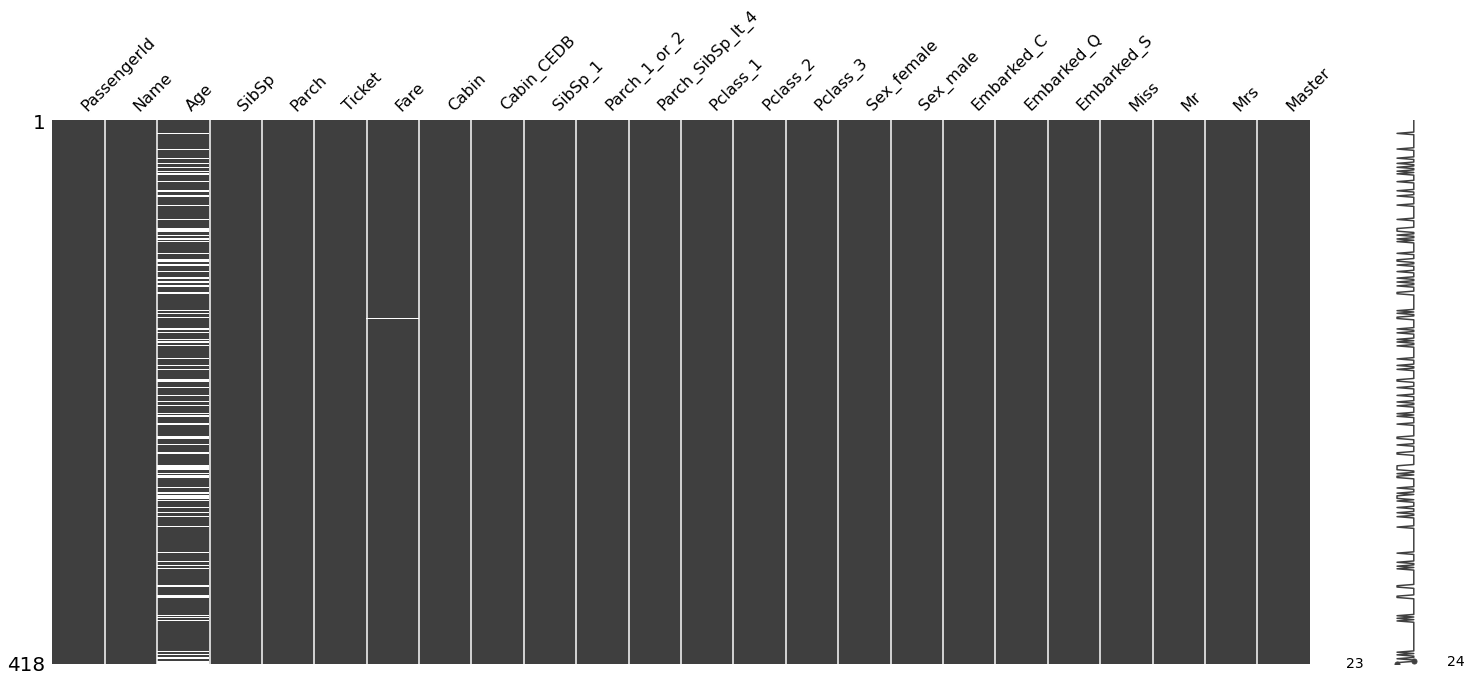

In [39]:
msno.matrix(test);

In [40]:
test['Fare'].fillna(test['Fare'].mean(), inplace=True)
test['Fare'] = scl.transform(test[['Fare']])

In [41]:
log.fit(train[features], train['Survived'])
preds = log.predict(test[features])

### Predictions on test dataset

In [42]:
submission = pd.read_csv('data/submission.csv')
submission['Survived'] = preds
submission.to_csv("data/submission.csv", index = False)

Submitting this prediction gives us an accuracy of 76.076%. As we know that the accuracy metric is highly sensitive to your defined threshold, we could manually change it's value to improve the accuracy model.

In [43]:
submission['Survived'] = (pd.DataFrame(preds)[0] < 0.3).astype(int)
submission.to_csv("data/submission.csv", index = False)

If we use the 0.3 threshold, we have an accuracy of 79.425%. That's significantly better than our previous result, however it is not exactly fair, as it was tuned using the submission's results directly.

We can do a similar approach tuning the threshold value using our train data:

In [44]:
from sklearn.metrics import accuracy_score

kf = KFold(2, shuffle = True, random_state = 0)

outer_scores = [] 

for i in range(0, 101):
    inner_scores = []
    for train_ix, test_ix in kf.split(train):
        log.fit(train.loc[train_ix, features], train.loc[train_ix, 'Survived'])
        preds = log.predict_proba(train.loc[test_ix, features])
        
        inner_scores.append(metrics.accuracy_score((pd.DataFrame(preds)[0] < i/100).astype(int),
                           train.loc[test_ix, 'Survived']))
    
    outer_scores.append(np.mean(inner_scores))    

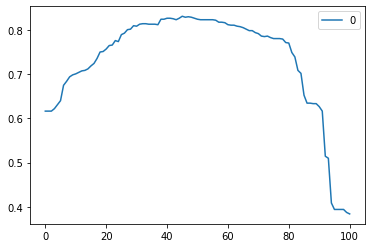

In [45]:
pd.DataFrame(outer_scores).plot();

In [46]:
print(max(outer_scores), outer_scores.index(max(outer_scores)))

0.8305310626291127 45


Here the max accuracy value occurs when the threshold value is equal to 0.46 with an validation accuracy of 83.05%.

In [47]:
log.fit(train[features], train['Survived'])
preds = log.predict_proba(test[features])

submission['Survived'] = (pd.DataFrame(preds)[0] < 0.46).astype(int)
submission.to_csv("data/submission.csv", index = False)

Submitting this predictions gives us a score of 77.511%, better than our initial submission.

# Clustering
Something that often helps when trying to maximize your prediction scores, is using a cluster variable.

In [48]:
from sklearn.cluster import KMeans

outer_scores = [] 
for i in range(1, 10, 1):
    kf = KFold(2, shuffle = True, random_state = 0)
    
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(train[features])
    
    train_cluster = pd.DataFrame(kmeans.labels_, columns = ['cluster'])
    train_cluster = pd.get_dummies(train_cluster.astype(str))

    temp_features = pd.DataFrame(pd.concat([train[features], train_cluster], axis = 1))
    
    accuracy_scores = []
    for train_ix, test_ix in kf.split(temp_features):
        log.fit(temp_features.loc[train_ix], train.loc[train_ix, 'Survived'])
        preds = log.predict(temp_features.loc[test_ix])

        accuracy_scores.append(metrics.accuracy_score(train.loc[test_ix, 'Survived'], preds))

    outer_scores.append(np.mean(accuracy_scores))

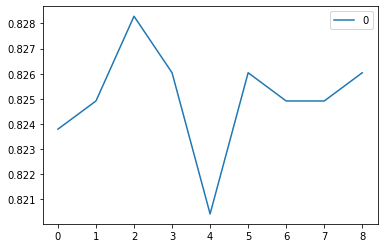

In [49]:
pd.DataFrame(outer_scores).plot();

In [50]:
print(max(outer_scores), outer_scores.index(max(outer_scores)))

0.8282863908903109 2


This means that we can have better predictions when incluting clusters variables in the model. 

Here, a k = 2 in the KMeans algorithmn gives us a performance of 82.83%. Better than our previous model.

In [51]:
kmeans = KMeans(n_clusters = 2, random_state = 0)
kmeans.fit(train[features])

train_cluster = pd.DataFrame(kmeans.labels_, columns = ['cluster'])
train_cluster = pd.get_dummies(train_cluster.astype(str))

train = pd.DataFrame(pd.concat([train, train_cluster], axis = 1))
features = [f for f in train.columns if f not in ['Survived', 'PassengerId']]

# Finding a better model
After treating our data and feature engineering, the focus now is getting a better model. We can start using several models without too much tuning to discover which ones are the most promising, then we work on those ones. The 0.5 threshold will be used initially as some models return different concepts when using the *predict_proba* method.

## Linear Regression

In [88]:
log = LinearRegression()

kf = KFold(2, shuffle = True, random_state = 0)

accuracy_scores = []
for train_ix, test_ix in kf.split(train):
    log.fit(train.loc[train_ix, features], train.loc[train_ix, 'Survived'])
    preds = log.predict(train.loc[test_ix, features])
    preds = (preds > 0.5).astype(int)

    accuracy_scores.append(metrics.accuracy_score(train.loc[test_ix, 'Survived'], preds))

print(np.mean(accuracy_scores))

0.8294099863959289


## RandomForestClassifier

In [89]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    
    model = RandomForestClassifier(
        n_estimators = trial.suggest_int('n_estimators', 10, 250),
        max_depth = trial.suggest_int('max_depth', 3, 12),
        max_features = trial.suggest_int('max_features', 1, 17),
        random_state = 0
    )
    
    kf = KFold(2, shuffle = True, random_state = 0)
    kf.split(train)
    
    accuracy_scores = []
    
    for train_ix, test_ix in kf.split(train):
        model.fit(train.loc[train_ix, features], train.loc[train_ix, 'Survived'])
        preds = model.predict_proba(train.loc[test_ix, features])[:,0]
        preds = (pd.DataFrame(preds) < 0.46).astype(int)
        
        
        accuracy_scores.append(metrics.accuracy_score(train.loc[test_ix, 'Survived'], preds))
        
    return np.mean(accuracy_scores)
    

# 3. Create a study object and optimize the objective function.

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)

In [92]:
print(study.best_trial.values)
study.best_params

[0.8417493827782536]


{'n_estimators': 234, 'max_depth': 7, 'max_features': 9}

## SVC

In [93]:
def objective(trial):
    
    model = SVC(
        C = trial.suggest_float('C', 1e-6, 10),
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    )
    
    kf = KFold(2, shuffle = True, random_state = 0)
    kf.split(train)
    
    accuracy_scores = []
    
    for train_ix, test_ix in kf.split(train):
        model.fit(train.loc[train_ix, features], train.loc[train_ix, 'Survived'])
        preds = model.predict(train.loc[test_ix, features])
        
        accuracy_scores.append(metrics.accuracy_score(train.loc[test_ix, 'Survived'], preds))
        
    return np.mean(accuracy_scores)
    
    
# 3. Create a study object and optimize the objective function.

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)

In [94]:
print(study.best_trial.values)
study.best_params

[0.8282838716178768]


{'C': 0.4392210545263198, 'kernel': 'linear'}

## ElasticNet

In [95]:
def objective(trial):
    
    model = ElasticNet(
        alpha = trial.suggest_float('alpha', 1e-6, 10),
        l1_ratio = trial.suggest_float('l1_ratio', 1e-6, 1),
        max_iter = 100000
    )
    
    kf = KFold(2, shuffle = True, random_state = 0)
    kf.split(train)
    
    accuracy_scores = []
    
    for train_ix, test_ix in kf.split(train):
        model.fit(train.loc[train_ix, features], train.loc[train_ix, 'Survived'])
        preds = model.predict(train.loc[test_ix, features])
        preds = (pd.DataFrame(preds) > 0.5).astype(int)
        
        accuracy_scores.append(metrics.accuracy_score(train.loc[test_ix, 'Survived'], preds))
        
    return np.mean(accuracy_scores)
    
    
# 3. Create a study object and optimize the objective function.

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)

In [96]:
print(study.best_trial.values)
study.best_params

[0.8316571774071648]


{'alpha': 0.00581196173367679, 'l1_ratio': 0.11705849757776753}

### Initial Results

- LogisticRegression: 82.38%;
- LinearRegression: 82.94%;
- RandomForestClassifier: 84.18%;
- SVC: 82.83%;
- ElasticNet: 83.28%;

# Model Averaging 
Using the labels predictions.

In [154]:
log = LogisticRegression()
lm = LinearRegression()
rf = RandomForestClassifier(n_estimators = 234, max_depth = 7, max_features = 9)
svc = SVC(C = 0.4392210545263198, kernel = 'linear')
en = ElasticNet(alpha = 0.00581196173367679, l1_ratio = 0.11705849757776753, random_state = 0)

In [158]:
th = 0.5
predictions = pd.DataFrame(train['Survived'].copy())
predictions['log'] = np.nan
predictions['lm'] = np.nan
predictions['rf'] = np.nan
predictions['svc'] = np.nan
predictions['en'] = np.nan

for fold1, fold2 in kf.split(train):
    log.fit(train.loc[fold1, features], train.loc[fold1, 'Survived'])
    lm.fit(train.loc[fold1, features], train.loc[fold1, 'Survived'])
    rf.fit(train.loc[fold1, features], train.loc[fold1, 'Survived'])
    svc.fit(train.loc[fold1, features], train.loc[fold1, 'Survived'])
    en.fit(train.loc[fold1, features], train.loc[fold1, 'Survived'])

    predictions.loc[fold2,'log'] = log.predict_proba(train.loc[fold2, features])[:,1] > th
    predictions.loc[fold2,'lm'] = lm.predict(train.loc[fold2, features]) > th
    predictions.loc[fold2,'rf'] = rf.predict_proba(train.loc[fold2, features])[:,1] > th
    predictions.loc[fold2,'svc'] = svc.predict(train.loc[fold2, features])
    predictions.loc[fold2,'en'] = en.predict(train.loc[fold2, features]) > th

metrics.accuracy_score(train['Survived'], predictions.iloc[:,1:6].apply(sum, axis = 1) > 2.5)

0.8338945005611672

In [159]:
predictions

,Survived,log,lm,rf,svc,en
0,0,False,False,False,0.0,False
1,1,True,True,True,1.0,True
2,1,True,True,True,1.0,True
3,1,True,True,True,1.0,True
4,0,False,False,False,0.0,False
...,...,...,...,...,...,...
886,0,False,False,False,0.0,False
887,1,True,True,True,1.0,True
888,0,True,True,False,1.0,True
889,1,False,False,False,0.0,False


In [100]:
pd.DataFrame(log.predict_proba(train.loc[fold2, features]))[[0]] < th
# predictions.loc[fold2,'log'] = log.predict(train.loc[fold2, features])
# metrics.accuracy_score(train['Survived'], predictions.iloc[:,1:6].apply(sum, axis = 1) > 2.5)

,0
0,True
1,False
2,False
3,True
4,True
...,...
440,False
441,True
442,True
443,False


In [74]:
predictions.iloc[:,1:6].apply(sum, axis = 1) > 2.5

0      False
1       True
2       True
3       True
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Length: 891, dtype: bool

In [69]:
th = 0.5
test_predictions = pd.DataFrame(test['PassengerId'])

test_predictions['log'] = log.predict(test[features])
test_predictions['lm'] = (lm.predict(test[features]) > th).astype(int)
test_predictions['rf'] = rf.predict(test[features])
test_predictions['svc'] = svc.predict(test[features])
test_predictions['en'] = (en.predict(test[features] > th).astype(int))

In [73]:
(test_predictions.iloc[:,1:6].apply(sum, axis = 1) > 2.5).astype(int)

0      0
1      1
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    1
Length: 418, dtype: int32

In [74]:
submission = pd.read_csv('data/submission.csv')
submission['Survived'] = (test_predictions.iloc[:,1:6].apply(sum, axis = 1) > 2.5).astype(int)
submission.to_csv("data/submission.csv", index = False)